# Risk

A key ingredient of portfolio construction is the ability to predict portfolio risk (in particular, with a risk-model) to be able to properly size the positions. Of course, an important assumption of the markowitz optimisation is the normality of returns. In this section, we evaluate the non-normality of backtest pnls.

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.display import Image

Building on previous sections, we first load the helper functions already defined:. 

In [2]:
from ml4pmt.metrics import sharpe_ratio, drawdown 
from ml4pmt.plot import line, bar, scatter
from ml4pmt.dataset import load_kf_returns
from ml4pmt.backtesting import MeanVariance, Backtester

returns_data = load_kf_returns(cache_dir="data")
ret = returns_data['Monthly']['Average_Value_Weighted_Returns'][:'1999']

INFO:ml4pmt.dataset:logging from cache directory: data/12_Industry_Portfolios


## Risk in the industry momentum backtest

Given that the data is monthly, we re-estimate the model every month and the maximum train window is 12 months. 

In [3]:
transform_X = lambda x: x.rolling(12).mean().values
transform_y = lambda x: x.shift(-1).values
features = transform_X(ret)
target = transform_y(ret)

We first compute the Industry momentum benchmark. 

In [4]:
m = Backtester(MeanVariance(), ret).train(features, target)
h0, pnl0, estimators0 = m.h_, m.pnl_, m.estimators_

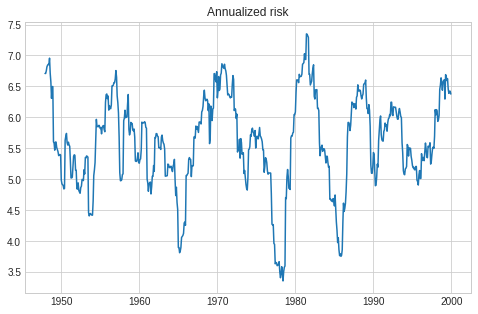

In [5]:
line(pnl0.rolling(36).std().mul(np.sqrt(12)), title='Annualized risk', legend=False, start_date='1945')

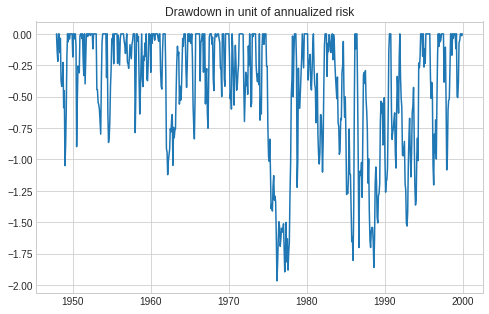

In [6]:
line(pnl0.pipe(drawdown), title='Drawdown in unit of annualized risk', legend=False, start_date='1945')

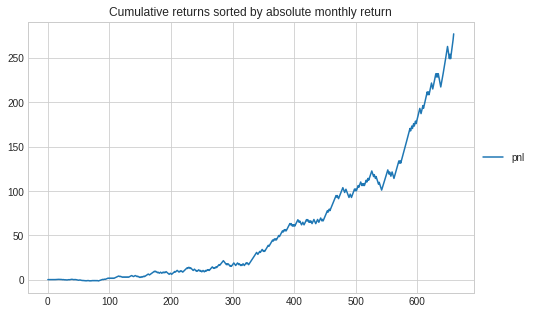

In [7]:
line(pnl0.rename('pnl').to_frame().assign(pnl_abs=lambda x: x.pnl.abs()).sort_values('pnl_abs').reset_index(drop=True)['pnl'], 
     cumsum=True, title='Cumulative returns sorted by absolute monthly return', legend_sharpe_ratio=False)

## Return covariance eigenvalues

The risk-model is defined here as the covariance of returns $V$. To understand its impact on the backtest, it is important to remember that in the mean-variance optimisation, it is the inverse of the covariance matrix $V^{-1}$ that is used. 

Viewed from the point of view of a singular value decomposition, the smallest eigenvalues of $V$ are not only estimated with noise, but their impact is magnified in $V^{-1}$, leading to potentially significant noise in the estiamte of positions. 

In [8]:
for train, test in m.cv.split(ret): 
    break

In [9]:
U, D, _ = np.linalg.svd(ret.iloc[train].cov())

The graph below shows that the largest eigenvalue is two-order of magnitude larger than the smallest one. 

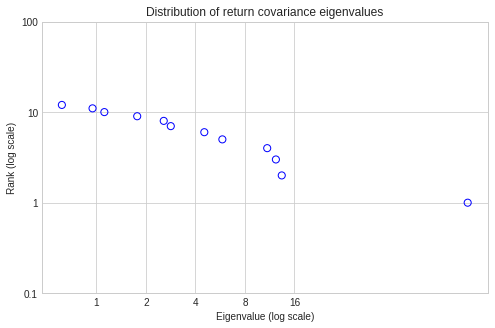

In [10]:
df = pd.Series(D, np.arange(1, 13))
scatter(df, xscale='log', yscale='log', xlabel='Eigenvalue (log scale)', ylabel='Rank (log scale)', 
        xticks=[1, 2, 4, 8, 16], yticks=[ .1, 1, 10, 100], title='Distribution of return covariance eigenvalues')

In [11]:
print(f"The ratio of the largest to the smallest eigenvalue is {D[0]/D[-1]:.1f}")

The ratio of the largest to the smallest eigenvalue is 293.1


## Risk model estimation

The insight of Ledoit and Wolf (2004): use a weighted average of two matrices to reduce estimation error

- the empirical covariance matrix V is asymptotically an unbiased estimated – but with a slow convergence for sample samples

- there are biased estimators but with a faster rate of convergence –- for instance the diagonal D of V -- and on smaller samples, such biased estimators can be more efficient than the unbiased ones

- The covariance matrix used in the portfolio optimisation is 

$$V_{\omega} = \omega D + (1-\omega) V.$$

How to determine $\omega$? Ledoit and Wolf (2004) minimize a norm that applies to
matrices (Frobenius norm)

For a given portfolio $h$, the risk-bias is given by 

$$ \text {RiskBias}  = Std \left[\frac{h^T r}{\sqrt{h^T  \hat{V}(\omega) h }} \right] -1 , $$
where the variance is evaluated over empirical returns. 

In [12]:
from sklearn.covariance import LedoitWolf, ShrunkCovariance

The default value of the `shrinkage` parameter for `ShrunkCovariance` is 0.1. When `shrinkage=0`, there is no shrinkage and when `shrinkage=1`, all the off-diagonal terms are set to zero and the covariance matrix is diagonal.   

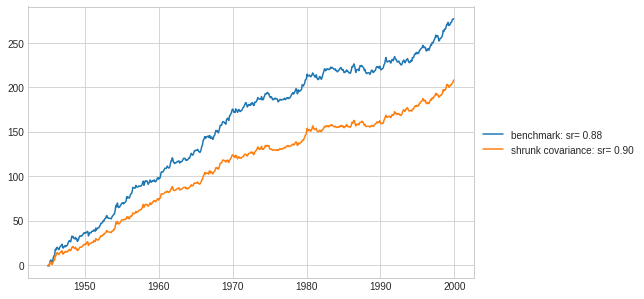

In [13]:
transform_V_ = lambda x: ShrunkCovariance(shrinkage=0.1).fit(x).covariance_
m = Backtester(MeanVariance(transform_V=transform_V_), ret).train(features, target)
h, pnl, estimators = m.h_, m.pnl_, m.estimators_
line({'benchmark': pnl0, 'shrunk covariance': pnl}, cumsum=True)

The estimation of risk with the shrunk covariance is much closer to the ex-ante risk (of 1). 

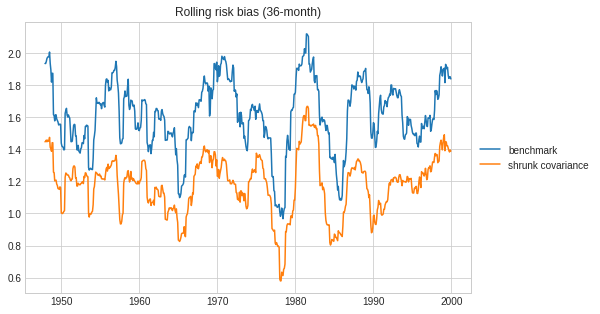

In [14]:
line({'benchmark': pnl0.rolling(36).std(), 'shrunk covariance': pnl.rolling(36).std()}, 
     title='Rolling risk bias (36-month)')

The ratio of the largest to the smallest eigenvalue is an order of magnitude smaller for the backtest with the shrunk covariance relative to the benchmark. 

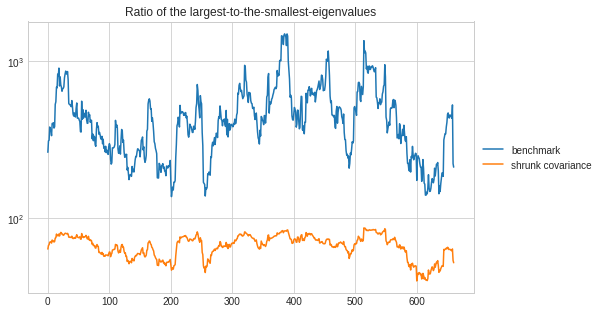

In [15]:
get_eigenvalues = lambda estimators: pd.DataFrame([np.linalg.svd(m.V_, compute_uv=False) for m in estimators])
ratio_largest_smallest_eigenvalue = lambda x: x.pipe(lambda x: x.iloc[:,0]/x.iloc[:,-1])

eigenvalues0 = get_eigenvalues(estimators0)
eigenvalues = get_eigenvalues(estimators)

line({'benchmark': eigenvalues0.pipe(ratio_largest_smallest_eigenvalue),
      'shrunk covariance': eigenvalues.pipe(ratio_largest_smallest_eigenvalue)}, yscale='log', 
    title='Ratio of the largest-to-the-smallest-eigenvalues')

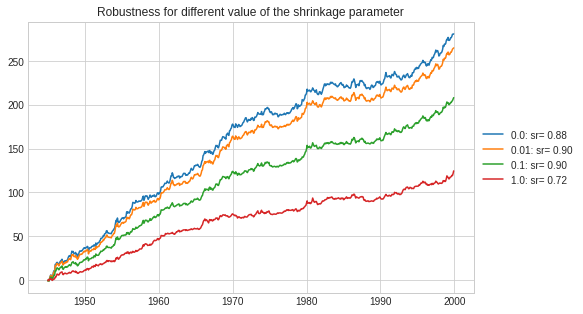

In [16]:
pnls = {}
for shrinkage in [0, .01, .1,  1]: 
    transform_V_ = lambda x: ShrunkCovariance(shrinkage=shrinkage).fit(x).covariance_
    estimator = MeanVariance(transform_V=transform_V_)
    pnls[shrinkage] = Backtester(estimator,ret).train(features, target).pnl_
line(pnls, cumsum=True, title='Robustness for different value of the shrinkage parameter')

A related shrinkage is to use the `LedoitWolf` method to determine the shrinkage and it yield similar performance. 

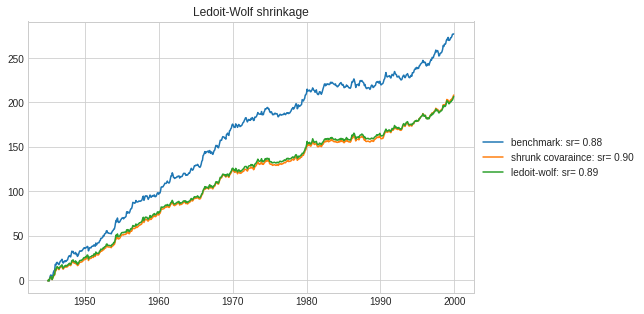

In [17]:
transform_V_ = lambda x: LedoitWolf().fit(x).covariance_
estimator = MeanVariance(transform_V=transform_V_)
pnl_ = Backtester(estimator,ret).train(features, target).pnl_
line({'benchmark': pnl0, 'shrunk covaraince': pnl, 'ledoit-wolf': pnl_}, 
     cumsum=True, title='Ledoit-Wolf shrinkage')

The key empirical point is that the sharpe ratio is maximized for a covariance that involves a small amount of shrinkage.

## Non-normality

At the stock-level, non-normality (e.g. skewness or kurtosis) may not be a significant problem:
- the portfolio might be short a stock with negative skewness

-  part of the stock kurtosis might diversify away at the portfolio level.

But factor-level non-normality is harder to diversify – especially the returns of strategy based on risk-premia (which are generally non-normally distributed):

- by definition, in risk-off environments, these strategies do not pay off and the left tails of the return distribution can be very “thick" leading to “rare disasters"

In this section, we discuss how to document non-normality:

- use some test statistics that involve skewness and kurtosis. 

- illustrate some methods using industry momentum.

The statistics of higher moments: 

-  $skewness =  \frac{E[(x - \bar{x})^3]}{\sigma_x^3}$ 

-  $kurtosis = \frac{E[(x - \bar{x})^4]}{\sigma_x^4}$

- Jarque-Bera statistics $JB = \frac{T}{6} \left(skewness^2 + \frac{(kurtosis-3)^2}{4} \right)$ 

- If the observations $\{x_1,..,x_T\}$ are independant and follow a Normal distribution, then 

    1. $skewness=0$ 

    1. $kurtosis=3$ 

    1. $JB$ follows of \textit{Chi-squared distribution with two degrees of freedom}. 

- The third assertion provides a way to test whether a variable is Normally distributed. 

In [18]:
from scipy.stats import kurtosis, skew, jarque_bera

**Normally distributed random data**:

- we can _not_ reject the null hypothesis that the data follows is a Normal distribution! 

In [19]:
(T, N) = ret.shape

In [20]:
x = np.random.normal(0, 1, T)   # create random values based on a normal distribution

print(f'Excess kurtosis of normal distribution (should be 0): {kurtosis(x):.3f}')
print(f'Skewness of normal distribution (should be 0): {skew(x):.3f}')
print(f'Jarque beta of normal distribution (should be 0): {jarque_bera(x)[0]:.3f}')

Excess kurtosis of normal distribution (should be 0): 0.003
Skewness of normal distribution (should be 0): 0.037
Jarque beta of normal distribution (should be 0): 0.206


In [21]:
kurtosis(np.random.normal(0, 1, T), fisher=False)

2.985736122206215

**Uniformly distributed random data**: 

- we can reject at any confidence level the null hypothesis that the data follows a Normal distribution! 

In [22]:
x = np.random.uniform(0, 1, T)   # create random values based on a normal distribution

print(f'Excess kurtosis of normal distribution (should be 0): {kurtosis(x):.3f}')
print(f'Skewness of normal distribution (should be 0): {skew(x):.3f}')
print(f'Jarque beta of normal distribution (should be 0): {jarque_bera(x)[0]:.3f}')

Excess kurtosis of normal distribution (should be 0): -1.153
Skewness of normal distribution (should be 0): 0.013
Jarque beta of normal distribution (should be 0): 48.923


**Industry momentum data**: 

- we can also reject the null hypothesis of a Normal distribution 

In [23]:
x = pnl

print(f'Excess kurtosis of normal distribution (should be 0): {kurtosis(x):.3f}')
print(f'Skewness of normal distribution (should be 0): {skew(x):.3f}')
print(f'Jarque beta of normal distribution (should be 0): {jarque_bera(x)[0]:.3f}')

Excess kurtosis of normal distribution (should be 0): 0.643
Skewness of normal distribution (should be 0): -0.139
Jarque beta of normal distribution (should be 0): 13.482


 The test in the notebook shows that the normality assumption is easily rejected for the momentum strategy return – there are a lot of observations (T large) and significant deviations.

## The statistics of rolling sharpe ratio

We now focus on 3-year rolling sharpe ratio:

- A 3-year horizon is the natural horizon to evaluate the performance of investment strategies.

- Significant underperformance over 3 years is almost always a show-stopper!

- In particular, we assess the impact of skewness and kurtosis on the rolling sharpe ratio.

**Lemma** [Lo, 1996]. When the underlying data is iid Normally distributed, the limiting distribution of the estimated \textit {monthly} sharpe ratio $\hat{S}$ (relative to the true unobserved $S$) is 
$$
\sqrt{T} (\hat{S} - S) \rightarrow N\left(0, 1 + \frac{IR^2}{2}\right) 
$$
*Proof*. For independently Normally distributed returns, we have
$$
\sqrt{T} \left[ \begin {array}{c} \hat{\mu} - \mu \\ \hat{\sigma}^2- \sigma^2  \end {array} \right] \rightarrow N \left( \left[ \begin {array}{c} 0 \\ 0 \end {array} \right];  \left[ \begin {array}{cc} \sigma^2 & 0 \\ 0 & 2 \sigma^4  \end {array} \right]  \right)
$$
For $S = g(\mu,\sigma^2) = \frac{\mu}{\sqrt{\sigma^2}}$, the asymptotic variance of $\hat{S}$ is 
$$
 \left[ \begin {array}{c} \frac{\partial g}{\partial \mu} \\ \frac{\partial g}{\partial (\sigma^2)} \end {array} \right]^T \left[ \begin {array}{cc} \sigma^2 &  0 \\ 0 & 2 \sigma^4  \end {array} \right]  \left[ \begin {array}{c} \frac{\partial g}{\partial \mu} \\ \frac{\partial g}{\partial (\sigma^2)} \end {array} \right]  = \frac{1}{\sigma^2} \sigma^2 +   \left(- \frac{\mu}{2\sigma^3}\right)^2 (2 \sigma^4)
$$

**Corollary.** The minimum \textit {monthly} $S_0$ for a monthly strategy where the Sharpe ratio is always statistically different from 0 at the 5\%-confidence level over a window of $T$ months is given by 

$$S_0 - 1.96 \sqrt{\frac{1+\frac{S_0^2}{2}}{T}} =0  \Leftrightarrow  S_0 = \sqrt{\frac{1}{\frac{T}{1.96^2}-1/2}} $$

- Rule of thumb: for a 36-month horizon, then the monthly $S_0 \approx 0.35$ or after annualization 

$$ S_0^{\text {annualized}} \approx .35 \times  \sqrt{12} = 1.16 
$$

When the returns are not Normally distributed ($skewness \neq 0$ and (excess) $kurtosis\neq 0$), the Central Limit theorem still ensures the asymptotic normality. (In what follows, `kurtosis` refers to the "excess kurtosis.)


**Lemma** [Mertens, 2002] The asymptotic distribution of $\hat{S}$ is  

$$
\sqrt{T} (\hat{S} - S) \rightarrow N\left(0, V_{\infty} \right) 
$$
where $V_{\infty} = 1 + \frac{S^2}{2} - skewness \times S + \frac{kurtosis \times S^2}{4}$.

*Proof.* The asymptotic variance of $\left[\begin {array}{c} \hat{\mu} - \mu \\ \hat{\sigma}^2 - \sigma^2 \end {array} \right]$ is: 
$$
E\left[\begin {array}{cc} (r_t - \mu)^2 & (r_t - \mu)[(r_t - \mu)^2 - \sigma^2]\\ (r_t - \mu)[(r_t - \mu)^2 - \sigma^2] & [(r_t - \mu)^2 - \sigma^2]^2 \end {array} \right]\\
= \left[ \begin {array}{cc} \sigma^2 & E[(r_t - \mu)^3] \\ E[(r_t - \mu)^3] & 2 E[(r_t - \mu)^4] - \sigma^4  \end {array} \right]
$$

**Corollary.** The minimum $S_0(skewness, kurtosis)$ for a monthly strategy where the information is always statistically different from 0 at the 5%-confidence level over a window of $T$ months is increasing in *kurtosis* and decreasing in *skewness*. 

*Proof.* The function $f(S,skewness,kurtosis)$ 
$$
= S - 1.96 \sqrt{\frac{ 1 + \frac{S^2}{2} - skewness \times S + \frac{kurtosis \times S^2}{4}}{T}  }
$$
is increasing in $S$ and *skewness* and decreasing in *kurtosis*, so that $S_0$ defined by $f(S_0,skewness,kurtosis)=0$ is decreasing in *skewness* and increasing in *kurtosis*.

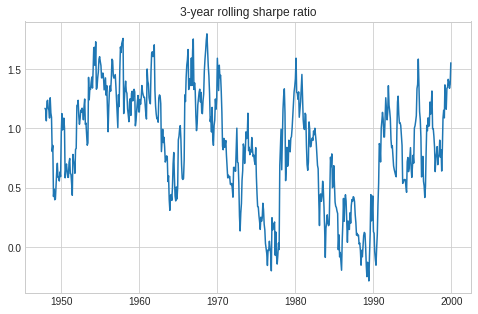

In [24]:
sr3y = pnl.rolling(36).apply(sharpe_ratio)
line(sr3y, legend=False, title='3-year rolling sharpe ratio', start_date='1945')

Below we compute the two lower bounds for the sharpe ratio.

In [25]:
sr3y_lb = sr3y - 1.96 * np.sqrt((1 + .5 * sr3y**2) / 36) * np.sqrt(12)
skew3y = pnl.rolling(36).apply(skew)
kurtosis3y = pnl.rolling(36).apply(kurtosis)
sr3y_lb_bis = sr3y - 1.96 * np.sqrt((1+.5 * sr3y**2 - skew3y *sr3y + .25*kurtosis3y *sr3y**2)/36) * np.sqrt(12)

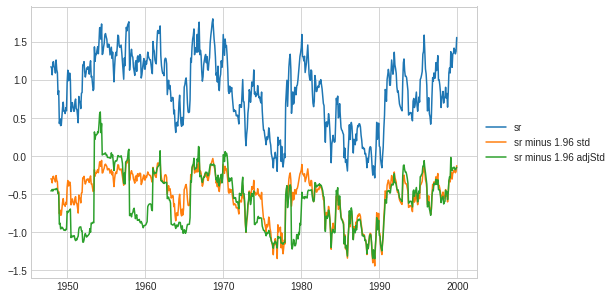

In [26]:
line({'sr': sr3y, 'sr minus 1.96 std': sr3y_lb, 'sr minus 1.96 adjStd': sr3y_lb_bis}, start_date='1945')

Even generic momentum strategies (including industry momentum) have a fairly strong information ratio... 
-  ... but the performance includes kurtosis/skewness risk premia, with occasional deep underperformance over a 3-year horizon. 